# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-3)
# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.367089, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300552, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300047, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302550, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301167, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303344, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301279, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302135, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301086, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301520, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302751, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302785, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302207, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303652, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301038, Train acc

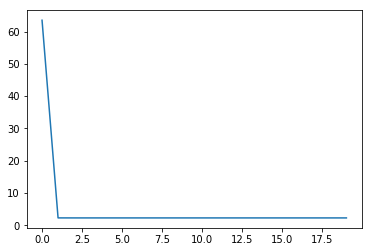

In [10]:
plt.plot(loss_history)

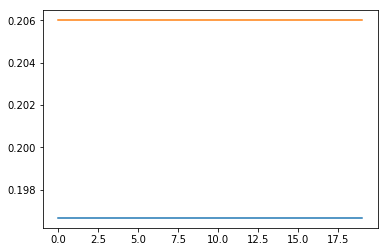

In [11]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 4.477455, Train accuracy: 0.223333, val accuracy: 0.227000
Loss: 3.307441, Train accuracy: 0.217778, val accuracy: 0.221000
Loss: 2.630796, Train accuracy: 0.209889, val accuracy: 0.216000
Loss: 2.432976, Train accuracy: 0.211667, val accuracy: 0.218000
Loss: 2.299323, Train accuracy: 0.207111, val accuracy: 0.214000
Loss: 2.225376, Train accuracy: 0.209000, val accuracy: 0.214000
Loss: 2.164636, Train accuracy: 0.212111, val accuracy: 0.219000
Loss: 2.357278, Train accuracy: 0.212556, val accuracy: 0.218000
Loss: 2.292182, Train accuracy: 0.215111, val accuracy: 0.219000
Loss: 2.282084, Train accuracy: 0.216889, val accuracy: 0.220000
Loss: 2.230655, Train accuracy: 0.214111, val accuracy: 0.218000
Loss: 2.242413, Train accuracy: 0.220778, val accuracy: 0.224000
Loss: 2.438257, Train accuracy: 0.223778, val accuracy: 0.225000
Loss: 2.149861, Train accuracy: 0.218222, val accuracy: 0.221000
Loss: 2.445436, Train accuracy: 0.225444, val accuracy: 0.235000
Loss: 2.252863, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

#trainer.compute_accuracy(val_X, val_y)
# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 7.372315, Train accuracy: 0.171556, val accuracy: 0.178000
Loss: 6.866657, Train accuracy: 0.203000, val accuracy: 0.226000
Loss: 6.518223, Train accuracy: 0.213222, val accuracy: 0.214000
Loss: 5.989601, Train accuracy: 0.215444, val accuracy: 0.213000
Loss: 5.694062, Train accuracy: 0.215889, val accuracy: 0.216000
Loss: 5.609747, Train accuracy: 0.216556, val accuracy: 0.214000
Loss: 5.183031, Train accuracy: 0.218000, val accuracy: 0.217000
Loss: 4.928319, Train accuracy: 0.216333, val accuracy: 0.219000
Loss: 4.728091, Train accuracy: 0.217111, val accuracy: 0.220000
Loss: 4.544668, Train accuracy: 0.216000, val accuracy: 0.221000
Loss: 4.390727, Train accuracy: 0.216556, val accuracy: 0.221000
Loss: 4.285611, Train accuracy: 0.216444, val accuracy: 0.222000
Loss: 3.981328, Train accuracy: 0.215778, val accuracy: 0.221000
Loss: 3.947577, Train accuracy: 0.215556, val accuracy: 0.222000
Loss: 3.832581, Train accuracy: 0.216222, val accuracy: 0.222000
Loss: 3.643637, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 8.033130, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 6.492887, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 6.292600, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 5.835474, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 5.175267, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 5.114466, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 4.839036, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 4.332513, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.923934, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 3.793648, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.649526, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.388257, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.343885, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.432993, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 3.164447, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.728196, Train acc

Loss: 0.714041, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.691944, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.867151, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.863245, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.821648, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.752296, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.762513, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.748121, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.794206, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.763842, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.788270, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.793778, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.715493, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.804586, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.802929, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.766411, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 7.140303, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 5.999131, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 6.343686, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 4.388766, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 2.898324, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 2.063525, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 3.828397, Train accuracy: 0.933333, val accuracy: 0.133333
Loss: 2.849780, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 2.852911, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 3.220178, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 7.172790, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 5.103165, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 5.097703, Train accuracy: 0.733333, val accuracy: 0.133333
Loss: 6.987226, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 4.642470, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 9.055120, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strength = [1e-4, 1e-5, 1e-6]
learning_rate_decay = [0.999, 0.9, 0.88]
hidden_layer_size = 175
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None
best_hyperparams = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

dataset = Dataset(train_X, train_y, val_X, val_y)

hyperparams = np.array(np.meshgrid(learning_rates, reg_strength, learning_rate_decay)).T.reshape(-1,3)
for hp in hyperparams:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = hp[1])
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=hp[0], learning_rate_decay=hp[2])
    loss, train_acc, val_acc = trainer.fit()
    if best_val_accuracy == None:
        best_val_accuracy = val_acc[-1]
        best_classifier = trainer
        loss_history = loss
        train_history = train_acc
        val_history = val_acc
        best_hyperparams = hp
    elif val_acc[-1] > best_val_accuracy:
        best_val_accuracy = val_acc[-1]
        best_classifier = trainer
        loss_history = loss
        train_history = train_acc
        val_history = val_acc
        best_hyperparams = hp

print('best validation accuracy achieved: %f' % best_val_accuracy)
print(best_hyperparams)

[[1.00e-03 1.00e-04 9.99e-01]
 [1.00e-03 1.00e-05 9.99e-01]
 [1.00e-03 1.00e-06 9.99e-01]
 [1.00e-04 1.00e-04 9.99e-01]
 [1.00e-04 1.00e-05 9.99e-01]
 [1.00e-04 1.00e-06 9.99e-01]
 [1.00e-05 1.00e-04 9.99e-01]
 [1.00e-05 1.00e-05 9.99e-01]
 [1.00e-05 1.00e-06 9.99e-01]
 [1.00e-03 1.00e-04 9.00e-01]
 [1.00e-03 1.00e-05 9.00e-01]
 [1.00e-03 1.00e-06 9.00e-01]
 [1.00e-04 1.00e-04 9.00e-01]
 [1.00e-04 1.00e-05 9.00e-01]
 [1.00e-04 1.00e-06 9.00e-01]
 [1.00e-05 1.00e-04 9.00e-01]
 [1.00e-05 1.00e-05 9.00e-01]
 [1.00e-05 1.00e-06 9.00e-01]
 [1.00e-03 1.00e-04 8.80e-01]
 [1.00e-03 1.00e-05 8.80e-01]
 [1.00e-03 1.00e-06 8.80e-01]
 [1.00e-04 1.00e-04 8.80e-01]
 [1.00e-04 1.00e-05 8.80e-01]
 [1.00e-04 1.00e-06 8.80e-01]
 [1.00e-05 1.00e-04 8.80e-01]
 [1.00e-05 1.00e-05 8.80e-01]
 [1.00e-05 1.00e-06 8.80e-01]]
Loss: 2.187675, Train accuracy: 0.237111, val accuracy: 0.232000
Loss: 2.002908, Train accuracy: 0.296222, val accuracy: 0.295000
Loss: 1.889504, Train accuracy: 0.352222, val accuracy: 0.3

Loss: 2.164196, Train accuracy: 0.257667, val accuracy: 0.260000
Loss: 2.247411, Train accuracy: 0.264111, val accuracy: 0.271000
Loss: 1.947980, Train accuracy: 0.271778, val accuracy: 0.279000
Loss: 1.976874, Train accuracy: 0.281000, val accuracy: 0.287000
Loss: 1.969848, Train accuracy: 0.288889, val accuracy: 0.294000
Loss: 2.056011, Train accuracy: 0.293778, val accuracy: 0.297000
Loss: 2.241863, Train accuracy: 0.183556, val accuracy: 0.196000
Loss: 2.337257, Train accuracy: 0.186556, val accuracy: 0.197000
Loss: 2.374602, Train accuracy: 0.191000, val accuracy: 0.201000
Loss: 2.336658, Train accuracy: 0.195111, val accuracy: 0.200000
Loss: 2.291668, Train accuracy: 0.195778, val accuracy: 0.206000
Loss: 2.262613, Train accuracy: 0.196222, val accuracy: 0.203000
Loss: 2.291003, Train accuracy: 0.194889, val accuracy: 0.205000
Loss: 2.230081, Train accuracy: 0.195889, val accuracy: 0.204000
Loss: 2.251647, Train accuracy: 0.196000, val accuracy: 0.203000
Loss: 2.271598, Train acc

Loss: 2.287567, Train accuracy: 0.197778, val accuracy: 0.187000
Loss: 2.214853, Train accuracy: 0.209333, val accuracy: 0.203000
Loss: 2.274580, Train accuracy: 0.215222, val accuracy: 0.212000
Loss: 2.322968, Train accuracy: 0.220000, val accuracy: 0.221000
Loss: 2.148816, Train accuracy: 0.223667, val accuracy: 0.225000
Loss: 2.263555, Train accuracy: 0.224778, val accuracy: 0.226000
Loss: 2.178193, Train accuracy: 0.227889, val accuracy: 0.229000
Loss: 2.134751, Train accuracy: 0.229556, val accuracy: 0.232000
Loss: 2.133743, Train accuracy: 0.229000, val accuracy: 0.230000
Loss: 2.204430, Train accuracy: 0.229889, val accuracy: 0.236000
Loss: 2.257819, Train accuracy: 0.230889, val accuracy: 0.237000
Loss: 2.110376, Train accuracy: 0.233778, val accuracy: 0.237000
Loss: 2.302423, Train accuracy: 0.234333, val accuracy: 0.237000
Loss: 2.096431, Train accuracy: 0.235222, val accuracy: 0.238000
Loss: 2.125552, Train accuracy: 0.235222, val accuracy: 0.239000
Loss: 2.190429, Train acc

Loss: 1.455212, Train accuracy: 0.548222, val accuracy: 0.555000
Loss: 1.568254, Train accuracy: 0.564111, val accuracy: 0.568000
Loss: 1.496244, Train accuracy: 0.573778, val accuracy: 0.577000
Loss: 1.456174, Train accuracy: 0.587222, val accuracy: 0.587000
Loss: 1.391031, Train accuracy: 0.597778, val accuracy: 0.589000
Loss: 1.699301, Train accuracy: 0.605111, val accuracy: 0.595000
Loss: 1.224461, Train accuracy: 0.607556, val accuracy: 0.600000
Loss: 1.932891, Train accuracy: 0.614778, val accuracy: 0.603000
Loss: 1.143640, Train accuracy: 0.617778, val accuracy: 0.601000
Loss: 1.316864, Train accuracy: 0.621000, val accuracy: 0.602000
Loss: 1.371951, Train accuracy: 0.623667, val accuracy: 0.608000
Loss: 1.595970, Train accuracy: 0.624667, val accuracy: 0.607000
Loss: 2.260912, Train accuracy: 0.226111, val accuracy: 0.228000
Loss: 2.047403, Train accuracy: 0.270778, val accuracy: 0.284000
Loss: 1.604927, Train accuracy: 0.337333, val accuracy: 0.351000
Loss: 1.727664, Train acc

Loss: 2.299848, Train accuracy: 0.151444, val accuracy: 0.141000
Loss: 2.318161, Train accuracy: 0.153000, val accuracy: 0.142000
Loss: 2.305902, Train accuracy: 0.153222, val accuracy: 0.142000
Loss: 2.244971, Train accuracy: 0.154111, val accuracy: 0.142000
Loss: 2.313547, Train accuracy: 0.155000, val accuracy: 0.142000
Loss: 2.268741, Train accuracy: 0.152000, val accuracy: 0.131000
Loss: 2.241638, Train accuracy: 0.166889, val accuracy: 0.143000
Loss: 2.289532, Train accuracy: 0.171778, val accuracy: 0.152000
Loss: 2.332772, Train accuracy: 0.176333, val accuracy: 0.159000
Loss: 2.254451, Train accuracy: 0.179333, val accuracy: 0.162000
Loss: 2.260202, Train accuracy: 0.181556, val accuracy: 0.172000
Loss: 2.186881, Train accuracy: 0.182778, val accuracy: 0.179000
Loss: 2.246296, Train accuracy: 0.184889, val accuracy: 0.182000
Loss: 2.314828, Train accuracy: 0.186556, val accuracy: 0.181000
Loss: 2.270169, Train accuracy: 0.187000, val accuracy: 0.185000
Loss: 2.261766, Train acc

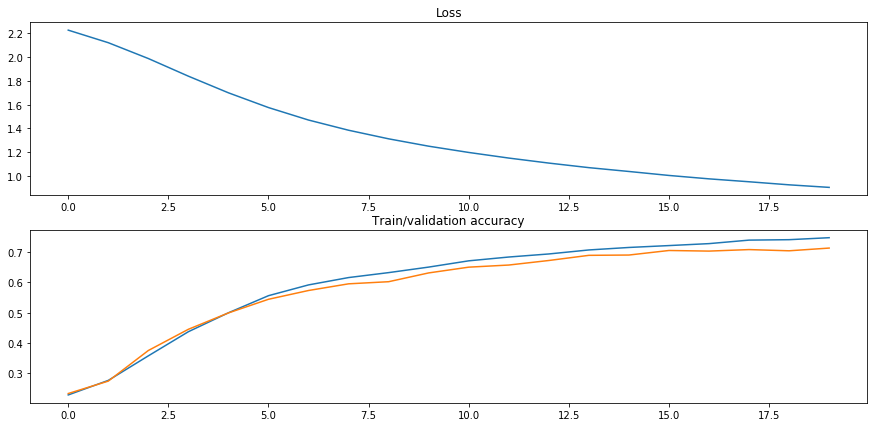

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [18]:
test_accuracy = best_classifier.compute_accuracy(test_X, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.657000
